In [1]:
import os
import sys
import time
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

# 獲取當前工作目錄
current_dir = os.getcwd()
version3_path = os.path.join(current_dir, "TrafficTDApython", "Version3", "tdamapper", "core_old.py")

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering
from tdamapper.plot import MapperLayoutInteractive, MapperPlot

from models import *
from utils_v3 import *
from plots import *

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
dataA2 = pd.read_csv("../Version3/Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("../Version3/Data/A1.csv")

## 納入資料
- 篩選每個月2萬筆：發生月份<br/>
- 大類別資料：道路型態大類別名稱、事故位置大類別名稱、車道劃分設施-分向設施大類別名稱、事故類型及型態大類別名稱、當事者區分-類別-大類別名稱-車種、當事者行動狀態大類別名稱<br/>
## 不納入資料
- 車輛撞擊部位大類別名稱-最初：屬性只有一種<br/>
- 肇因研判大類別名稱-個別: 他和肇因研判大類別名稱-主要幾乎一模一樣<br/>

In [3]:
select_lst = [
    '發生月份',
    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他',
    '肇因研判大類別名稱-主要',
]
# select_lst = dataA1.columns

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 速限範圍
    dist_df = dist_df[(dist_df['速限-第1當事者'] < 200) &
                      (dist_df['當事者事故發生時年齡'] < 100) &
                      (dist_df['當事者事故發生時年齡'] > 0)]

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

pass_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '人的狀態']
pass_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '人的狀態']

# drop
pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

pass_A2 = pass_A2[(pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄') &
                   (pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '不明')]
pass_A1 = pass_A1[(pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄') &
                   (pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '不明')]

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_21303/125018713.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_21303/125018713.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)


In [4]:
print(pass_A1.shape)
print(pass_A2.shape)

(58, 51)
(3038, 51)


In [4]:
# Concat
rbind_data = pd.concat([pass_A1, pass_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

# 處理年齡和速限
rbind_data = process_age_speed(rbind_data)

# Dummy
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()
# rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']

dummy_data: (3096, 117)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

由於人的狀態資料量已經很少，所以不進行下採樣

# Kmode

In [11]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)

print(data_for_kmode.columns)

cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k,
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


# pd.Series(all_results[4]['labels']).value_counts()
# rbind_data['Cluster'] = all_results[4]['labels']


KeyboardInterrupt



In [54]:
rbind_data['Cluster'] = all_results[2]['labels']

# MCA

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.120         3.67%                      3.67%
1              0.089         2.72%                      6.39%
2              0.082         2.53%                      8.91%
3              0.074         2.28%                     11.19%
4              0.069         2.12%                     13.32%
5              0.060         1.85%                     15.16%
6              0.056         1.71%                     16.87%
7              0.055         1.68%                     18.55%
8              0.053         1.62%                     20.18%
9              0.052         1.59%                     21.77%
10             0.050         1.53%                     23.30%
11             0.049         1.49%                     24.80%


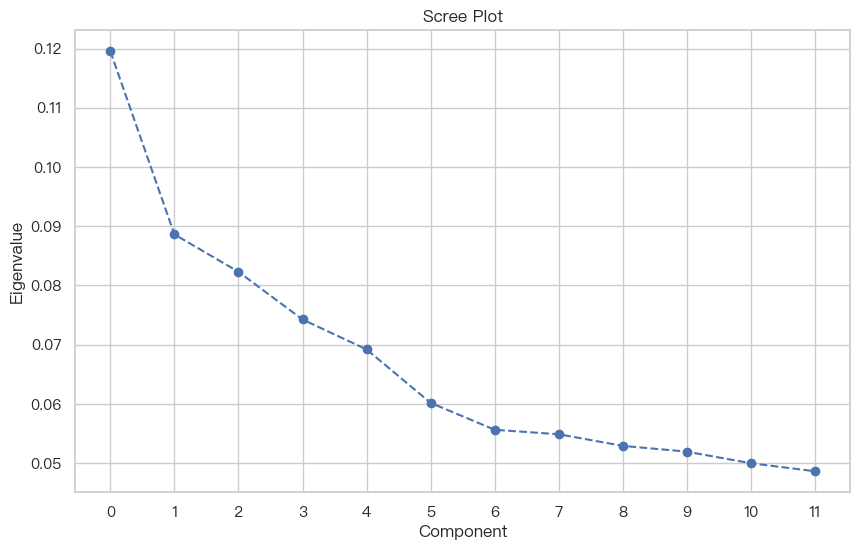

In [6]:
mca = prince.MCA(
    one_hot=False,
    n_components=12,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)
mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))

plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

# Gridsearch

In [8]:
Overlap = [4]
Interval = [7]
detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"../Version3/Gridsearch/Component12Pass/results_o{overlap}i{interval}_mac.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

detailed_results_df = pd.DataFrame(detailed_results)

overlap: 4, interval: 7


12/30/2024 04:10:33 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/30/2024 04:10:33 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/30/2024 04:10:33 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/30/2024 04:10:33 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/30/2024 04:10:33 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/30/2024 04:10:33 PM core WARNING: Unable to perform 

Results saved to ../Version3/Gridsearch/Component12Pass/results_o4i7_mac.pkl


In [5]:
output_file = '../Version3/Gridsearch/Component12Pass/results_o4i7.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)

# 正確分佈的seed = 87

In [10]:
# read pickle
with open('../Version3/ModelPerformance/pass_performance_svc.pkl', 'rb') as f:
    pass_decision_scores = pickle.load(f)

sorted_indices = np.argsort(pass_decision_scores['indices'])
y_decision_sorted = pass_decision_scores['decision_scores'][sorted_indices]
rbind_data['score'] = y_decision_sorted

In [ ]:
choose = 'score'

for i in [87]:
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=i, iterations=100)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, average_encoded_label, avg=True)
    full_info = mapper_plotter.extract_data()
    full_info['x'], full_info['y'] = -full_info['y'], full_info['x']
    mapper_plotter.map_colors(choose, size=0, threshold=0, range_lst=[-0.2, 0.1, 0.15, -0.18])
    mapper_plotter.plot(choose, avg=True, set_label=True, size=100000)
    # mapper_plotter.plot_3d_interactive(choose, avg=False, set_label=True, size=100000,
    #                                    save_path=f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o4i8_{choose}.html")

In [ ]:
lst = ['天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃''死亡', '受傷', 'Cluster', '顯著特徵']
lst = ['Cluster']

for choose in lst:
       try:   
              mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=44, iterations=100)
              mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
              full_info = mapper_plotter.extract_data()
              mapper_plotter.map_colors(choose, size=0, threshold=30, range_lst=[-0.2, 0.1, 0.15, -0.18])
              mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                     save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i7_{choose}.png")
       except Exception as e:
              print(e)
              continue

In [ ]:
choose = 'Cluster'

unique_categories = rbind_data[choose].unique()
for index in range(detailed_results_df.shape[0]):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")

# Polygon

In [8]:
print(len(get_unique_ids(full_info)))

3096


01/03/2025 09:24:31 PM legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


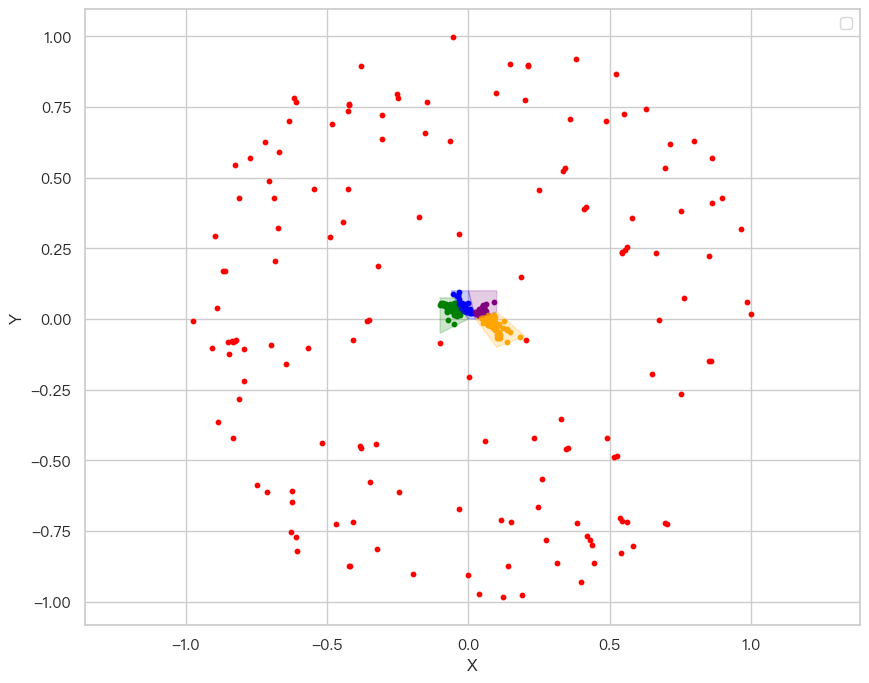

In [9]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.1, -0.05), (-0.1, 0.075), (-0.05, 0.075), (0, 0)])
rectangle2 = Polygon([(0, 0), (-0.05, 0.075), (-0.06, 0.1), (0, 0.1), (0.025, 0)])
rectangle3 = Polygon([(0.025, 0), (0, 0.1), (0.1, 0.1), (0.1, 0.025), (0.025, 0)]) 
rectangle4 = Polygon([(0.025, 0), (0.1, 0.025), (0.2, -0.06), (0.1, -0.1)]) 

# 限制會導致full_info的資料量減少
range_lst=[-0.2, 0.2, 0.2, -0.25]
# filtered_full_info = full_info[(full_info['x'] > range_lst[0]) & 
#           (full_info['y'] < range_lst[2]) & 
#           (full_info['x'] < range_lst[1]) & 
#           (full_info['y'] > range_lst[3])]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_2.shape[0] + label_3.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

plt.figure(figsize=(10, 8))

# Plot points inside each polygon
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# Fill polygons with semi-transparent colors
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# Formatting
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
# plt.title("Passanger Topology")
plt.show()

In [38]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes]
count_1 = [i for i in count_1 if i not in intersection_indexes]
count_2 = [i for i in count_2 if i not in intersection_indexes]
count_3 = [i for i in count_3 if i not in intersection_indexes]
count_out = [i for i in count_out if i not in intersection_indexes]


full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]
overlap_data = dummy_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + overlap_data.shape[0])
print(rbind_data.shape[0])

3096
3096


In [34]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

死亡
0    511
1     12
Name: count, dtype: int64
死亡
0    113
1      1
Name: count, dtype: int64
死亡
0    304
1      2
Name: count, dtype: int64
死亡
0    1787
1      32
2       1
Name: count, dtype: int64
死亡
0    150
1      9
Name: count, dtype: int64
死亡
0    173
1      1
Name: count, dtype: int64


In [14]:
# full_info.to_csv('../Version3/Data/PassData/full_info.csv', index=False)
# full_0.to_csv('../Version3/Data/PassData/full_0.csv', index=False)
# full_1.to_csv('../Version3/Data/PassData/full_1.csv', index=False)
# full_2.to_csv('../Version3/Data/PassData/full_2.csv', index=False)
# full_3.to_csv('../Version3/Data/PassData/full_3.csv', index=False)
# full_out.to_csv('../Version3/Data/PassData/full_out.csv', index=False)
# overlap_data.to_csv('../Version3/Data/PassData/overlap_data.csv', index=False)

# 統計分析

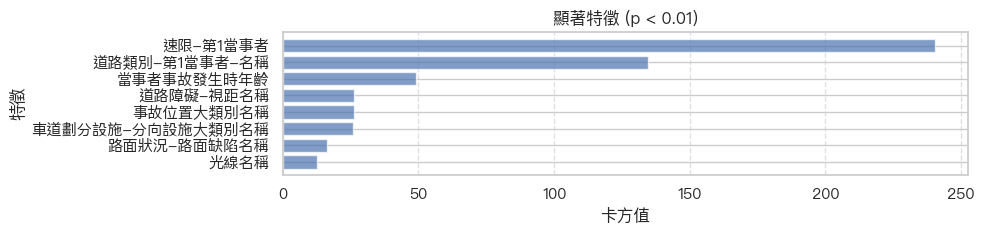

In [32]:
from scipy.stats import chi2_contingency

chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = rbind_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 2.5))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 道路類別-第1當事者-名稱

In [44]:
plot_column = '道路類別-第1當事者-名稱'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
道路類別-第1當事者-名稱,,,,,,
市區道路,442.0,96.0,254.0,1472.0,127.0,85.0
村里道路,41.0,6.0,23.0,201.0,33.0,28.0
其他,17.0,6.0,14.0,50.0,3.0,17.0
縣道,10.0,3.0,9.0,34.0,6.0,5.0
省道,8.0,2.0,4.0,28.0,1.0,11.0
鄉道,5.0,1.0,2.0,27.0,4.0,1.0
國道,0.0,0.0,0.0,0.0,0.0,11.0
專用道路,0.0,0.0,0.0,8.0,0.0,0.0
快速(公)道,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)

categories_to_merge = ["縣道", "省道", "鄉道", "國道", "專用道路", "快速(公)道"]
comparison_df.loc["其他"] += comparison_df.loc[categories_to_merge].sum()
comparison_df = comparison_df.drop(index=categories_to_merge)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
道路類別-第1當事者-名稱,,,,,,
市區道路,0.845124,0.842105,0.830065,0.808791,0.729885,0.534591
村里道路,0.078394,0.052632,0.075163,0.110440,0.189655,0.176101
其他,0.076482,0.105263,0.094771,0.080769,0.080460,0.289308


# 嚴重程度

In [47]:
def get_severity(input_data):
    """
    更新嚴重程度欄位邏輯：
    - 死亡 > 0 時，設定為 2
    - 死亡 = 0 且受傷 = 1 時，設定為 0
    - 死亡 = 0 且受傷 > 1 時，設定為 1
    """
    def severity_logic(row):
        if row['死亡'] > 0:
            return '死亡'
        elif row['死亡'] == 0 and row['受傷'] == 1:
            return '受傷1'
        elif row['死亡'] == 0 and row['受傷'] > 1:
            return '受傷1+'
        else:
            return 0

    input_data['嚴重程度'] = input_data.apply(severity_logic, axis=1)
    return input_data

full_0_s = get_severity(full_0)
full_1_s = get_severity(full_1)
full_2_s = get_severity(full_2)
full_3_s = get_severity(full_3)
full_out_s = get_severity(full_out)
overlap_data_s = get_severity(overlap_data)

In [48]:
plot_column = '嚴重程度'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
嚴重程度,,,,,,
Total,523,114,306,1820,174,159
受傷1,300,68,150,823,87,87
受傷1+,211,45,154,964,86,63
死亡,12,1,2,33,1,9


In [49]:
data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df.loc["Total"] = total_row
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
嚴重程度,,,,,,
Total,523.000000,114.000000,306.000000,1820.000000,174.000000,159.000000
受傷1,0.573614,0.596491,0.490196,0.452198,0.500000,0.547170
受傷1+,0.403442,0.394737,0.503268,0.529670,0.494253,0.396226
死亡,0.022945,0.008772,0.006536,0.018132,0.005747,0.056604


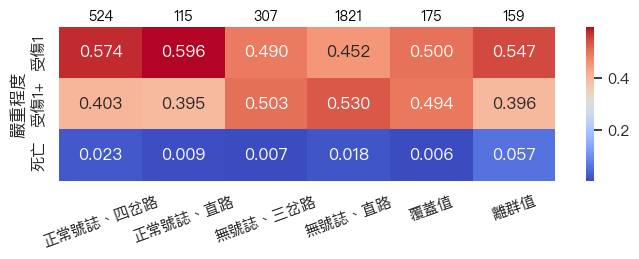

In [50]:
# 重新計算 Total 行，並添加到 DataFrame
comparison_df.loc["Total"] = comparison_df.sum(axis=0)

# 獲取 Total 行數據
total_row = comparison_df.loc["Total"]

# 提取僅包含數值的列，並移除 Total 行
numeric_df = comparison_df.select_dtypes(include=[float, int]).drop("Total")

# 繪製 heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(numeric_df.tail(3), annot=True, cmap='coolwarm', fmt=".3f")

# 添加總數標註在每個欄位的頂部
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

# 調整外觀
plt.xticks(rotation=20)
plt.show()
